## List of callbacks

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import * 
from fastai.basic_train import * 
from fastai.train import * 
from fastai import callbacks

fastai's training loop is highly extensible, with a rich *callback* system. See the [`callback`](/callback.html#callback) docs if you're interested in writing your own callback. See below for a list of callbacks that are provided with fastai, grouped by the module they're defined in.

Every callback that is passed to [`Learner`](/basic_train.html#Learner) with the `callback_fns` parameter will be automatically stored as an attribute. The attribute name is snake-cased, so for instance [`ActivationStats`](/callbacks.hooks.html#ActivationStats) will appear as `learn.activation_stats` (assuming your object is named `learn`).

## [`Callback`](/callback.html#Callback)

This sub-package contains more sophisticated callbacks that each are in their own module. They are (click the link for more details):

### [`LRFinder`](/callbacks.lr_finder.html#LRFinder)

Use Leslie Smith's [learning rate finder](https://www.jeremyjordan.me/nn-learning-rate/) to find a good learning rate for training your model. Let's see an example of use on the MNIST dataset with a simple CNN.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
def simple_learner(): return Learner(data, simple_cnn((3,16,16,2)), metrics=[accuracy])
learn = simple_learner()

The fastai librairy already has a Learner method called [`lr_find`](/train.html#lr_find) that uses [`LRFinder`](/callbacks.lr_finder.html#LRFinder) to plot the loss as a function of the learning rate

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


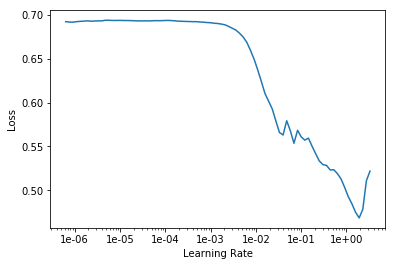

In [ ]:
learn.recorder.plot()

In this example, a learning rate around 2e-2 seems like the right fit.

In [ ]:
lr = 2e-2

### [`OneCycleScheduler`](/callbacks.one_cycle.html#OneCycleScheduler)

Train with Leslie Smith's [1cycle annealing](https://sgugger.github.io/the-1cycle-policy.html) method. Let's train our simple learner using the one cycle policy.

In [ ]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.109439,0.059349,0.980864,00:02
1,0.039582,0.023152,0.992149,00:02
2,0.019009,0.021239,0.991659,00:02


The learning rate and the momentum were changed during the epochs as follows (more info on the [dedicated documentation page](https://docs.fast.ai/callbacks.one_cycle.html)).

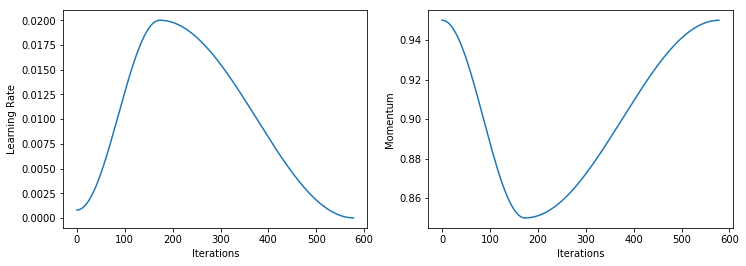

In [ ]:
learn.recorder.plot_lr(show_moms=True)

### [`MixUpCallback`](/callbacks.mixup.html#MixUpCallback)

Data augmentation using the method from [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412). It is very simple to add mixup in fastai :

In [ ]:
learn = Learner(data, simple_cnn((3, 16, 16, 2)), metrics=[accuracy]).mixup()

### [`CSVLogger`](/callbacks.csv_logger.html#CSVLogger)

Log the results of training in a csv file. Simply pass the CSVLogger callback to the Learner.

In [ ]:
learn = Learner(data, simple_cnn((3, 16, 16, 2)), metrics=[accuracy, error_rate], callback_fns=[CSVLogger])

In [ ]:
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.127259,0.098069,0.969578,0.030422,00:02
1,0.084601,0.068024,0.974975,0.025025,00:02
2,0.055074,0.047266,0.983317,0.016683,00:02


You can then read the csv.

In [ ]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy,error_rate
0,0,0.127259,0.098069,0.969578,0.030422
1,1,0.084601,0.068024,0.974975,0.025025
2,2,0.055074,0.047266,0.983317,0.016683


### [`GeneralScheduler`](/callbacks.general_sched.html#GeneralScheduler)

Create your own multi-stage annealing schemes with a convenient API. To illustrate, let's implement a 2 phase schedule.

In [ ]:
def fit_odd_shedule(learn, lr):
    n = len(learn.data.train_dl)
    phases = [TrainingPhase(n).schedule_hp('lr', lr, anneal=annealing_cos), 
              TrainingPhase(n*2).schedule_hp('lr', lr, anneal=annealing_poly(2))]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    total_epochs = 3
    learn.fit(total_epochs)

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
fit_odd_shedule(learn, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.176607,0.157229,0.946025,00:02
1,0.140903,0.133690,0.954367,00:02
2,0.130910,0.131156,0.956820,00:02


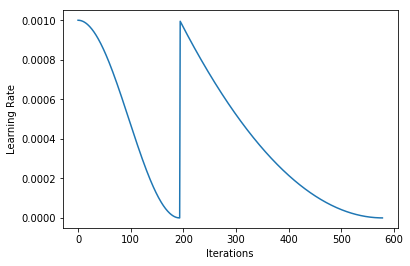

In [ ]:
learn.recorder.plot_lr()

### [`MixedPrecision`](/callbacks.fp16.html#MixedPrecision)

Use fp16 to [take advantage of tensor cores](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html) on recent NVIDIA GPUs for a 200% or more speedup.

### [`HookCallback`](/callbacks.hooks.html#HookCallback)

Convenient wrapper for registering and automatically deregistering [PyTorch hooks](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#forward-and-backward-function-hooks). Also contains pre-defined hook callback: [`ActivationStats`](/callbacks.hooks.html#ActivationStats).

### [`RNNTrainer`](/callbacks.rnn.html#RNNTrainer)

Callback taking care of all the tweaks to train an RNN.

### [`TerminateOnNaNCallback`](/callbacks.tracker.html#TerminateOnNaNCallback)

Stop training if the loss reaches NaN.

### [`EarlyStoppingCallback`](/callbacks.tracker.html#EarlyStoppingCallback)

Stop training if a given metric/validation loss doesn't improve.

### [`SaveModelCallback`](/callbacks.tracker.html#SaveModelCallback)

Save the model at every epoch, or the best model for a given metric/validation loss.

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
learn.fit_one_cycle(3,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.679189,0.646599,0.804220,00:02
1,0.527475,0.497290,0.908243,00:02
2,0.464756,0.462471,0.917076,00:02


In [ ]:
!ls ~/.fastai/data/mnist_sample/models

best.pth	 bestmodel_2.pth  model_1.pth  model_4.pth    stage-1.pth
bestmodel_0.pth  bestmodel_3.pth  model_2.pth  model_5.pth    tmp.pth
bestmodel_1.pth  model_0.pth	  model_3.pth  one_epoch.pth  trained_model.pth


### [`ReduceLROnPlateauCallback`](/callbacks.tracker.html#ReduceLROnPlateauCallback)

Reduce the learning rate each time a given metric/validation loss doesn't improve by a certain factor.

### [`PeakMemMetric`](/callbacks.mem.html#PeakMemMetric)

GPU and general RAM profiling callback

### [`StopAfterNBatches`](/callbacks.misc.html#StopAfterNBatches)

Stop training after n batches of the first epoch.

### [`LearnerTensorboardWriter`](/callbacks.tensorboard.html#LearnerTensorboardWriter)

Broadly useful callback for Learners that writes to Tensorboard. Writes model histograms, losses/metrics, embedding projector and gradient stats. 

## [`train`](/train.html#train) and [`basic_train`](/basic_train.html#basic_train)

### [`Recorder`](/basic_train.html#Recorder)

Track per-batch and per-epoch smoothed losses and metrics.

### [`ShowGraph`](/train.html#ShowGraph)

Dynamically display a learning chart during training.

### [`BnFreeze`](/train.html#BnFreeze)

Freeze batchnorm layer moving average statistics for non-trainable layers.

### [`GradientClipping`](/train.html#GradientClipping)

Clips gradient during training.